In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import numpy as np
import os
import glob
from tqdm import tqdm
import gc
import sklearn

import torchvision
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from fastai.vision.all import *
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
SEED = 5
FOLDS = [1,2,3,4,5]
PATH = 'C:/Users/TCrepin/perso/Projects/RSNA-Lumbar-Spine-Conditions-Severity-Prediction/' # Main path
DATA_PATH = PATH + 'dataset/' # Data folder
TRAIN_PATH = DATA_PATH + 'train_images/'# Training images folder
ENCODER_NAME = "resnet18"
PATCH_H = 512
PATCH_W = 512
ANGLE = 30
patch_size = 64
BS = 16
EPOCHS = 2

In [3]:
spinal = [
    'spinal_canal_stenosis_l1_l2',
    'spinal_canal_stenosis_l2_l3',
    'spinal_canal_stenosis_l3_l4',
    'spinal_canal_stenosis_l4_l5',
    'spinal_canal_stenosis_l5_s1'
]
coor = [
    'x_L1L2',
    'y_L1L2',
    'x_L2L3',
    'y_L2L3',
    'x_L3L4',
    'y_L3L4',
    'x_L4L5',
    'y_L4L5',
    'x_L5S1',
    'y_L5S1'
]

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def augment_image(image):
#   Randomly rotate the image.
    angle = torch.as_tensor(random.uniform(-ANGLE, ANGLE))
    image = torchvision.transforms.functional.rotate(
        image,angle.item(),
        interpolation=torchvision.transforms.InterpolationMode.BILINEAR
    )
    return image

def my_collate_fn(data):
    collation = [torch.cat(s) for s in zip(*data)]
    return collation
# https://www.kaggle.com/code/abhinavsuri/anatomy-image-visualization-overview-rsna-raids
# Function to display images
def display_images(images, title, max_images_per_row=4):
    # Calculate the number of rows needed
    num_images = len(images)
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # Ceiling division

    # Create a subplot grid
    fig, axes = plt.subplots(num_rows, max_images_per_row, figsize=(5, 1.5 * num_rows))
    
    # Flatten axes array for easier looping if there are multiple rows
    if num_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # Make it iterable for consistency

    # Plot each image
    for idx, image in enumerate(images):
        ax = axes[idx]
        ax.imshow(image, cmap='gray')  # Assuming grayscale for simplicity, change cmap as needed
        ax.axis('off')  # Hide axes

    # Turn off unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    fig.suptitle(title, fontsize=16)

    plt.tight_layout()

In [5]:
train = pd.read_csv(os.path.join(DATA_PATH, 'train_split.csv'))
train.tail()

,study_id,spinal_canal_stenosis_l1_l2,spinal_canal_stenosis_l2_l3,spinal_canal_stenosis_l3_l4,spinal_canal_stenosis_l4_l5,spinal_canal_stenosis_l5_s1,left_neural_foraminal_narrowing_l1_l2,left_neural_foraminal_narrowing_l2_l3,left_neural_foraminal_narrowing_l3_l4,left_neural_foraminal_narrowing_l4_l5,...,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1,fold
1970,4282019580,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,5.0
1971,4283570761,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,5.0
1972,4284048608,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,5.0
1973,4287160193,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,...,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,5.0
1974,4290709089,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,5.0


In [6]:
df_coor = pd.read_csv(os.path.join(DATA_PATH, 'train_label_coordinates.csv'))
df_coor.tail()

,study_id,series_id,instance_number,condition,level,x,y
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333
48691,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L5/S1,211.813953,259.534884


In [7]:
S = df_coor[
    df_coor['condition'] == 'Spinal Canal Stenosis'
].sort_values([
    'study_id',
    'series_id',
    'level'
]).reset_index(drop=True)
S.tail()

,study_id,series_id,instance_number,condition,level,x,y
9748,4290709089,3274612423,9,Spinal Canal Stenosis,L1/L2,181.668947,88.864569
9749,4290709089,3274612423,9,Spinal Canal Stenosis,L2/L3,174.227086,125.198358
9750,4290709089,3274612423,9,Spinal Canal Stenosis,L3/L4,174.227086,160.656635
9751,4290709089,3274612423,9,Spinal Canal Stenosis,L4/L5,182.544460,191.299590
9752,4290709089,3274612423,9,Spinal Canal Stenosis,L5/S1,194.363885,218.878249


In [8]:
S['x_mean_fraction'] = S['x']/S.groupby(['study_id','series_id'])['x'].mean().loc[[(study_id,series_id) for study_id,series_id in S[['study_id','series_id']].values]].values
S.tail()

,study_id,series_id,instance_number,condition,level,x,y,x_mean_fraction
9748,4290709089,3274612423,9,Spinal Canal Stenosis,L1/L2,181.668947,88.864569,1.001448
9749,4290709089,3274612423,9,Spinal Canal Stenosis,L2/L3,174.227086,125.198358,0.960425
9750,4290709089,3274612423,9,Spinal Canal Stenosis,L3/L4,174.227086,160.656635,0.960425
9751,4290709089,3274612423,9,Spinal Canal Stenosis,L4/L5,182.544460,191.299590,1.006274
9752,4290709089,3274612423,9,Spinal Canal Stenosis,L5/S1,194.363885,218.878249,1.071429


In [9]:
S = S[S['x_mean_fraction'] > .8]
S.tail()

,study_id,series_id,instance_number,condition,level,x,y,x_mean_fraction
9748,4290709089,3274612423,9,Spinal Canal Stenosis,L1/L2,181.668947,88.864569,1.001448
9749,4290709089,3274612423,9,Spinal Canal Stenosis,L2/L3,174.227086,125.198358,0.960425
9750,4290709089,3274612423,9,Spinal Canal Stenosis,L3/L4,174.227086,160.656635,0.960425
9751,4290709089,3274612423,9,Spinal Canal Stenosis,L4/L5,182.544460,191.299590,1.006274
9752,4290709089,3274612423,9,Spinal Canal Stenosis,L5/S1,194.363885,218.878249,1.071429


In [10]:
S['instance_number'] = S['instance_number'] - 1
S.tail()

,study_id,series_id,instance_number,condition,level,x,y,x_mean_fraction
9748,4290709089,3274612423,8,Spinal Canal Stenosis,L1/L2,181.668947,88.864569,1.001448
9749,4290709089,3274612423,8,Spinal Canal Stenosis,L2/L3,174.227086,125.198358,0.960425
9750,4290709089,3274612423,8,Spinal Canal Stenosis,L3/L4,174.227086,160.656635,0.960425
9751,4290709089,3274612423,8,Spinal Canal Stenosis,L4/L5,182.544460,191.299590,1.006274
9752,4290709089,3274612423,8,Spinal Canal Stenosis,L5/S1,194.363885,218.878249,1.071429


In [11]:
coordinates = {}
for study_id,df in S.groupby('study_id'):
    coordinates[study_id] = {}
for (study_id,series_id),df in tqdm(S.groupby(['study_id','series_id'])):
    coordinates[study_id][series_id] = {
                'L1/L2':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'instance_number':torch.nan
                },
                    'L2/L3':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'instance_number':torch.nan
                },
                'L3/L4':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'instance_number':torch.nan
                },
                'L4/L5':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'instance_number':torch.nan
                },
                'L5/S1':{
                    'x':torch.nan,
                    'y':torch.nan,
                    'instance_number':torch.nan
                }
    }
    
    for i in range(len(df)):
        row = df.iloc[i]
        coordinates[row['study_id']][row['series_id']][row['level']]['x'] = row['x']
        coordinates[row['study_id']][row['series_id']][row['level']]['y'] = row['y']
        coordinates[row['study_id']][row['series_id']][row['level']]['instance_number'] = row['instance_number']

100%|██████████| 1974/1974 [00:01<00:00, 1745.01it/s]


In [12]:
S =  S[[
    'study_id',
    'series_id'
]].groupby([
    'study_id',
    'series_id'
]).count().reset_index()
S.tail()

,study_id,series_id
1969,4282019580,1547999333
1970,4283570761,453728183
1971,4284048608,3767301072
1972,4287160193,1507070277
1973,4290709089,3274612423


In [13]:
v = np.zeros((len(S),15))
for i in tqdm(range(len(S))):
    row = S.iloc[i]
    k = 0
    for level in coordinates[row['study_id']][row['series_id']]:
        v[i,k:k+3] = list(coordinates[row['study_id']][row['series_id']][level].values())
        k += 3

100%|██████████| 1974/1974 [00:00<00:00, 9882.69it/s]


In [14]:
S[[
    'x_L1L2',
    'y_L1L2',
    'i_L1L2',
    'x_L2L3',
    'y_L2L3',
    'i_L2L3',
    'x_L3L4',
    'y_L3L4',
    'i_L3L4',
    'x_L4L5',
    'y_L4L5',
    'i_L4L5',
    'x_L5S1',
    'y_L5S1',
    'i_L5S1'
]] = v
S.tail()

,study_id,series_id,x_L1L2,y_L1L2,i_L1L2,x_L2L3,y_L2L3,i_L2L3,x_L3L4,y_L3L4,i_L3L4,x_L4L5,y_L4L5,i_L4L5,x_L5S1,y_L5S1,i_L5S1
1969,4282019580,1547999333,217.588235,104.823529,10.0,202.305085,151.864407,10.0,196.411765,193.764706,10.0,203.470588,241.058824,10.0,214.058824,274.235294,10.0
1970,4283570761,453728183,252.096578,148.066797,8.0,239.788300,209.608186,8.0,232.427696,265.899924,8.0,235.546307,315.797706,8.0,254.013013,364.807609,8.0
1971,4284048608,3767301072,290.154631,203.001570,9.0,276.591052,269.915228,9.0,272.974097,335.020408,9.0,280.208006,391.083203,11.0,295.580063,443.529042,11.0
1972,4287160193,1507070277,391.235190,235.644570,7.0,369.435472,321.805360,7.0,373.587800,391.356841,7.0,397.463681,456.755994,7.0,427.568054,516.964739,7.0
1973,4290709089,3274612423,181.668947,88.864569,8.0,174.227086,125.198358,8.0,174.227086,160.656635,8.0,182.544460,191.299590,8.0,194.363885,218.878249,8.0


In [15]:
S = S.merge(train,left_on='study_id',right_on='study_id')
S.tail()

,study_id,series_id,x_L1L2,y_L1L2,i_L1L2,x_L2L3,y_L2L3,i_L2L3,x_L3L4,y_L3L4,...,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1,fold
1969,4282019580,1547999333,217.588235,104.823529,10.0,202.305085,151.864407,10.0,196.411765,193.764706,...,Normal/Mild,Normal/Mild,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Moderate,5.0
1970,4283570761,453728183,252.096578,148.066797,8.0,239.788300,209.608186,8.0,232.427696,265.899924,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,5.0
1971,4284048608,3767301072,290.154631,203.001570,9.0,276.591052,269.915228,9.0,272.974097,335.020408,...,Normal/Mild,Normal/Mild,Severe,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Severe,Normal/Mild,5.0
1972,4287160193,1507070277,391.235190,235.644570,7.0,369.435472,321.805360,7.0,373.587800,391.356841,...,Severe,Moderate,Moderate,Normal/Mild,Normal/Mild,Normal/Mild,Moderate,Moderate,Normal/Mild,5.0
1973,4290709089,3274612423,181.668947,88.864569,8.0,174.227086,125.198358,8.0,174.227086,160.656635,...,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,Normal/Mild,5.0


In [16]:
mask = S[[
    'x_L1L2',
    'x_L2L3',
    'x_L3L4',
    'x_L4L5',
    'x_L5S1'
]].isna().values
mask += S[[
    'y_L1L2',
    'y_L2L3',
    'y_L3L4',
    'y_L4L5',
    'y_L5S1'
]].isna().values
mask += S[[
    'i_L1L2',
    'i_L2L3',
    'i_L3L4',
    'i_L4L5',
    'i_L5S1'
]].isna().values
mask = mask > 0
mask[-5:]
v = S[spinal].values
v[mask] = 'UNK'
S[spinal] = v

In [17]:
S.groupby('fold').count()

,study_id,series_id,x_L1L2,y_L1L2,i_L1L2,x_L2L3,y_L2L3,i_L2L3,x_L3L4,y_L3L4,...,left_subarticular_stenosis_l1_l2,left_subarticular_stenosis_l2_l3,left_subarticular_stenosis_l3_l4,left_subarticular_stenosis_l4_l5,left_subarticular_stenosis_l5_s1,right_subarticular_stenosis_l1_l2,right_subarticular_stenosis_l2_l3,right_subarticular_stenosis_l3_l4,right_subarticular_stenosis_l4_l5,right_subarticular_stenosis_l5_s1
fold,,,,,,,,,,,,,,,,,,,,,
1.0,395,395,382,382,382,391,391,391,395,395,...,368,383,394,395,394,368,383,394,395,395
2.0,395,395,374,374,374,384,384,384,395,395,...,353,372,393,394,390,354,373,394,395,392
3.0,395,395,381,381,381,382,382,382,393,393,...,360,374,395,394,394,360,374,395,394,394
4.0,394,394,382,382,382,388,388,388,393,393,...,365,383,394,393,392,366,383,394,393,392
5.0,395,395,380,380,380,387,387,387,395,395,...,364,380,395,395,393,365,379,395,395,394


In [18]:
class Sagittal_T2_spine_discriminator_Dataset(Dataset):
    def __init__(self, df, VALID=False, P=patch_size):
        self.data = df
        self.VALID = VALID
        self.P = P
        self.resize = torchvision.transforms.Resize((PATCH_H,PATCH_W),antialias=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        
        
        sample = TRAIN_PATH + str(row['study_id']) + '/'+str(row['series_id'])

        images = [x.replace('\\','/') for x in glob.glob(sample+'/*.dcm')]
        images.sort(reverse=False, key=lambda x: int(x.split('/')[-1].replace('.dcm', '')))

        instance_numbers = row[[
            'i_L1L2',
            'i_L2L3',
            'i_L3L4',
            'i_L4L5',
            'i_L5S1'
        ]].values

        image = torch.stack([
            torch.as_tensor(pydicom.dcmread(x).pixel_array.astype(np.float32)) for x in images
        ]).float().to(device)
        image = image/image.max()
        D,H,W = image.shape

        c = torch.as_tensor([x for x in row[coor]]).view(5,2).float()
        missing = c.isnan().sum(1) > 0
        c[missing] = torch.as_tensor([H/2,W/2])

        if H > W:
            d = W
            h = (H - d)//2
            image = image[:,h:h+d]
            c[:,1] -= h
            H = W
        elif H < W:
            d = H
            w = (W - d)//2
            image = image[:,:,w:w+d]
            c[:,0] -= w
            W = H

        image = self.resize(image)
        image = nn.functional.pad(image,[self.P]*4,'reflect')
        c[:,1] = c[:,1]*PATCH_H/H + self.P
        c[:,0] = c[:,0]*PATCH_W/W + self.P
        c = c.long()

        crops = torch.stack([
            image[
                :,
                xy[1]-self.P:xy[1]+self.P,
                xy[0]-self.P:xy[0]+self.P
            ] for xy in c
        ])

        image = torch.zeros(5,D,2*self.P,2*self.P).to(device)
        label = torch.zeros(5,D).long().to(device) - 100
        for i in range(5):
            if ~missing[i]:
                instance_number = instance_numbers[i].astype(int)
                pickeable = torch.ones(D).bool()
                pickeable[instance_number] = False
                image[i,0] = crops[i,instance_number]
                k = 1
                if instance_number > 0:
                    pickeable[instance_number-1] = False
                    image[i,1] = crops[i,instance_number-1]
                    k += 1
                if instance_number < D - 1:
                    pickeable[instance_number+1] = False
                    image[i,2] = crops[i,instance_number+1]
                    k += 1
                if instance_number > 1: pickeable[instance_number-2] = False
                if instance_number < D - 2: pickeable[instance_number+2] = False
                
                pickeable = torch.arange(D)[pickeable]
                picked = pickeable
                image[i,k:len(picked)+k] = crops[i,picked]

                label[i,:k] = 1
                label[i,k:len(picked)+k] = 0

                if not self.VALID:
                    image[i] = augment_image(image[i].reshape(-1,2*self.P,2*self.P)).reshape(D,2*self.P,2*self.P)
            
        image = image[:,:,self.P//2:self.P//2+self.P,self.P//2:self.P//2+self.P]

        mask = label != -100
        image = image[mask]
        label = label[mask]

        return image,label

In [19]:
ds = Sagittal_T2_spine_discriminator_Dataset(S)

tensor([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,

        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,

        0, 0], device='cuda:0')


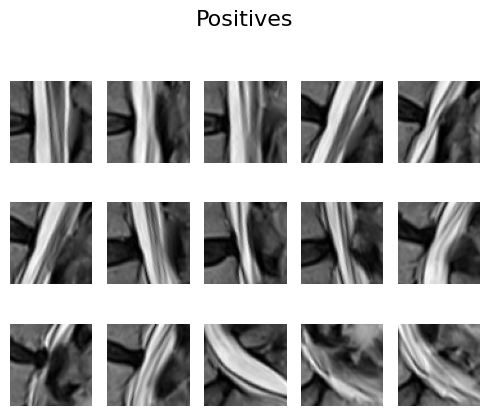

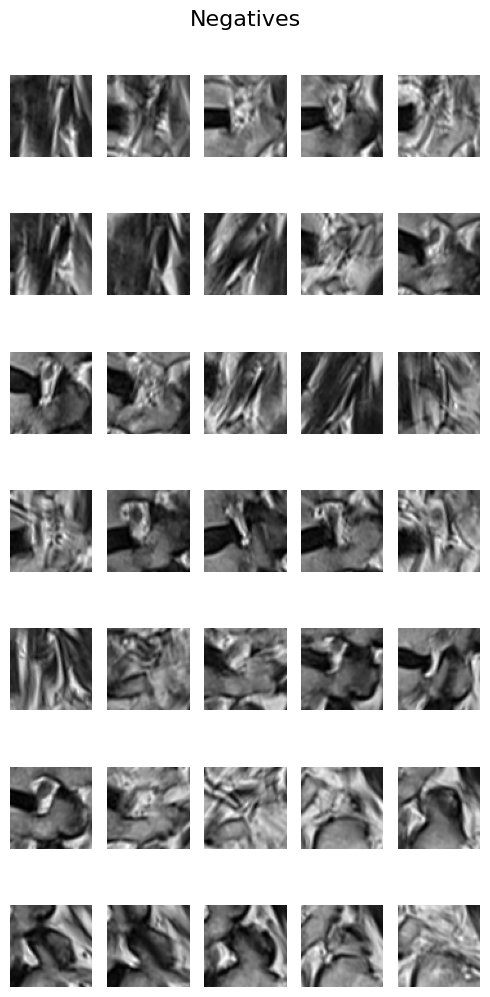

In [20]:
sample,label = ds.__getitem__(np.random.randint(len(ds)))
print(label)
display_images(sample[label == 1].cpu(),'Positives',max_images_per_row=5)
display_images(sample[label == 0].cpu(),'Negatives',max_images_per_row=5)

In [21]:
del ds
gc.collect()

95183

In [22]:
class Sagittal_T2_spine_Discriminator(nn.Module):
    def __init__(self, dim=512):
        super().__init__()
        CNN = torchvision.models.resnet18(weights='DEFAULT')
        W = nn.Parameter(CNN.conv1.weight.sum(1, keepdim=True))
        CNN.conv1 = nn.Conv2d(1, patch_size, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        CNN.conv1.weight = W
        CNN.fc = nn.Identity()
        self.emb = CNN.to(device)
        self.proj_out = nn.Linear(dim,2).to(device)
    
    def forward(self, x):        
        x = self.emb(x.view(-1,1,patch_size,patch_size))
        x = self.proj_out(x.view(-1,512))
        return x

In [23]:
negatives = 116965
positives = 29207
total = negatives + positives

def myLoss(preds,target):
    target = target.view(-1)
    return nn.CrossEntropyLoss(weight=torch.as_tensor([total/(negatives*2),total/(positives*2)]).to(device))(preds,target)

epoch,train_loss,valid_loss,time
0,0.056662,0.040248,05:45
1,0.037880,0.037943,05:21


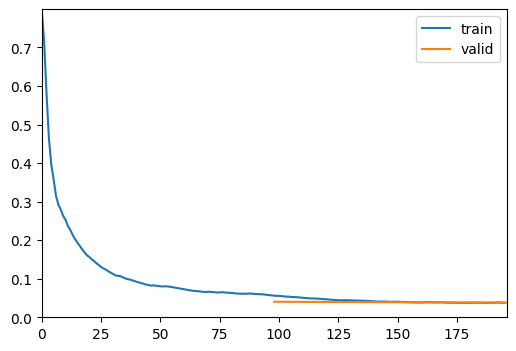

epoch,train_loss,valid_loss,time
0,0.056893,0.040149,05:37
1,0.038870,0.033085,05:21


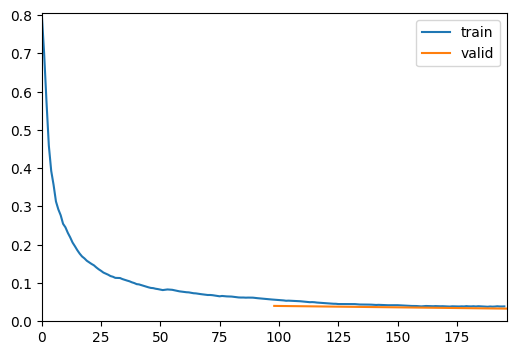

epoch,train_loss,valid_loss,time
0,0.057333,0.042033,05:19
1,0.038625,0.034829,05:24


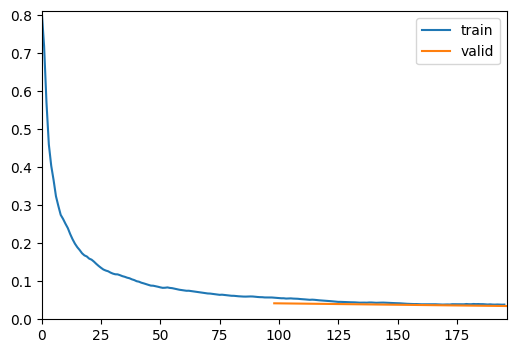

epoch,train_loss,valid_loss,time
0,0.054242,0.041616,05:35
1,0.036329,0.036415,05:26


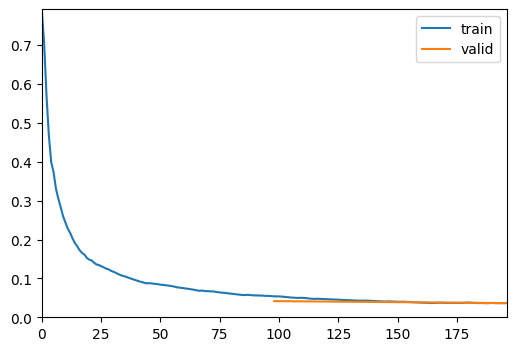

epoch,train_loss,valid_loss,time
0,0.056225,0.043707,05:24
1,0.036946,0.036673,05:22


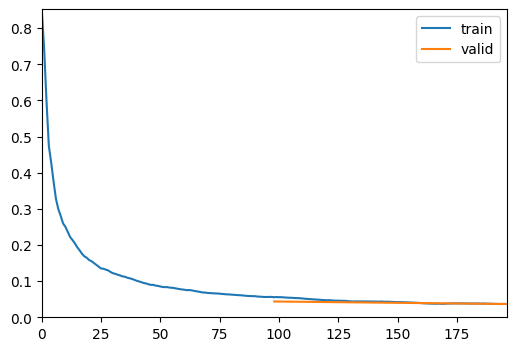

In [24]:
for f in FOLDS:
    seed_everything(SEED)
    model = Sagittal_T2_spine_Discriminator()
    
    df = S
    tdf = df[df.fold != f]
    vdf = df[df.fold == f]
    tds = Sagittal_T2_spine_discriminator_Dataset(tdf)
    vds = Sagittal_T2_spine_discriminator_Dataset(vdf,VALID=True)
    tdl = torch.utils.data.DataLoader(
        tds,
        batch_size=BS,
        shuffle=True,
        drop_last=True,
        collate_fn=my_collate_fn
    )
    vdl = torch.utils.data.DataLoader(
        vds,
        batch_size=BS,
        shuffle=False,
        collate_fn=my_collate_fn
    )
    dls = DataLoaders(tdl,vdl)

    n_iter = len(tds)//BS

    learn = Learner(
        dls,
        model,
        loss_func=myLoss,
        cbs=[
            ShowGraphCallback(),
            GradientClip(3.0)
        ]
    )
    learn.fit_one_cycle(EPOCHS, lr_max=1e-3, wd=0.05, pct_start=0.02)
    torch.save(model,'Sagittal_T2_spine_discriminator_'+str(f))
    del model,df,tdf,vdf,tds,vds,tdl,vdl,dls,learn
    gc.collect()

In [25]:
y_pred = []
y_true = []
for f in FOLDS:
    model = torch.load('Sagittal_T2_spine_discriminator_'+str(f)) 
    df = S
    vdf = df[df.fold == f]
    vds = Sagittal_T2_spine_discriminator_Dataset(vdf,VALID=True)
    vdl = torch.utils.data.DataLoader(
        vds,
        batch_size=BS,
        shuffle=False,
        collate_fn=my_collate_fn
    )
    with torch.no_grad():
        for images,target in tqdm(vdl):
            target = target.view(-1).tolist()
            preds = model(images).argmax(-1).tolist()
            y_pred = y_pred + preds
            y_true = y_true + target

    del model,df,vdf,vds,vdl
    gc.collect()

sklearn.metrics.confusion_matrix(y_true, y_pred)

100%|██████████| 25/25 [01:01<00:00,  2.46s/it]

100%|██████████| 25/25 [01:02<00:00,  2.50s/it]

100%|██████████| 25/25 [01:04<00:00,  2.59s/it]

100%|██████████| 25/25 [01:02<00:00,  2.50s/it]

100%|██████████| 25/25 [01:02<00:00,  2.52s/it]


array([[115453,   1512],
       [   332,  28875]], dtype=int64)

In [26]:
negatives = sum([y == 0 for y in y_true])
positives = sum([y == 1 for y in y_true])
total = negatives + positives
print(negatives,positives,total)

116965 29207 146172
